<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Создание-признаков-для-выборок-и--их-исследование" data-toc-modified-id="Создание-признаков-для-выборок-и--их-исследование-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание признаков для выборок и  их исследование</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод-по-проведенному-исследовательскому-анализу-данных-(EDA):" data-toc-modified-id="Промежуточный-вывод-по-проведенному-исследовательскому-анализу-данных-(EDA):-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Промежуточный вывод по проведенному исследовательскому анализу данных (EDA):</a></span></li></ul></li><li><span><a href="#Выбор-моделей-и-их-обучение" data-toc-modified-id="Выбор-моделей-и-их-обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выбор моделей и их обучение</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Постановка задачи 

В этом задании мы решаем задачу геоаналитики. Надо предсказать успешность (score) объекта ритейла. Признаки и выборки должны быть синтезированы искусственно.

Целевая метрика: mae

Выборки:
- train.csv - обучающая выборка,
- test.csv - тестовая выборка,
- features.csv - дополнительные признаки. Координаты отличаются в train.csv, test.csv и features.csv. 
Тем не менее, эта информация может оказаться очень полезной. Надо подумать, как можно соединить признаки с обучающей и тестовыми выборками.

Обучающая выборка train.csv
- id - уникальный идентификатор объекта ритейла
- lat - широта
- lon - долгота
- score - успешность объекта ритейла


Тестовая выборка test.csv
- id - уникальный идентификатор объекта ритейла
- lat - широта
- lon - долгота
- score - успешность объекта ритейла


Пример решения sample_submission.csv
- id - уникальный идентификатор объекта ритейла
- score - предсказание успешности объекта ритейла

Признаки features.csv
- lat - широта
- lon - долгота
- nearest_airport_distance_km - расстояние до ближайшего аэропорта (в км)
- nearest_restaurants_count - количество ресторанов в радиусе 1 км

**Импортируем необходимые библиотеки:**

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

## Создание признаков для выборок и  их исследование

In [2]:
# Генерация случайных данных
# Устанавливаем seed для воспроизводимости результатов
np.random.seed(0)

# Генерация широты и долготы для обучающей выборки
train_lat = np.random.uniform(low=50.0, high=55.0, size=(1000,))
train_lon = np.random.uniform(low=30.0, high=35.0, size=(1000,))
train_score = (train_lat * train_lon) / 10 + np.random.normal(loc=0, scale=5, size=(1000,))

# Генерация широты и долготы для тестовой выборки
test_lat = np.random.uniform(low=50.0, high=55.0, size=(500,))
test_lon = np.random.uniform(low=30.0, high=35.0, size=(500,))
test_score = (test_lat * test_lon) / 10 + np.random.normal(loc=0, scale=5, size=(500,))

# Создание обучающего и тестового DataFrame
train_df = pd.DataFrame({'id': np.arange(1, len(train_lat) + 1), 'lat': train_lat, 'lon': train_lon, 'score': train_score})
max_train_id = train_df['id'].max()  # Находим максимальное значение id в обучающей выборке
test_df = pd.DataFrame({'id': np.arange(max_train_id + 1, max_train_id + len(test_lat) + 1), 'lat': test_lat, 'lon': test_lon, 'score': test_score})

# Генерация дополнительных признаков из координат
train_df['lat_lon_ratio'] = train_df['lat'] / train_df['lon']
test_df['lat_lon_ratio'] = test_df['lat'] / test_df['lon']

# Сохранение в CSV файлы
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Вывод первых строк данных
print("Обучающая выборка:")
print(train_df.head())
print("\nТестовая выборка:")
print(test_df.head())

Обучающая выборка:
   id        lat        lon       score  lat_lon_ratio
0   1  52.744068  32.964401  173.342763       1.600031
1   2  53.575947  30.050318  167.834501       1.782875
2   3  53.013817  32.379131  163.377412       1.637283
3   4  52.724416  33.543852  177.626222       1.571806
4   5  52.118274  30.219877  149.578416       1.724636

Тестовая выборка:
     id        lat        lon       score  lat_lon_ratio
0  1001  52.383020  31.385331  166.878067       1.669029
1  1002  54.686468  30.676756  171.567296       1.782668
2  1003  54.667998  34.651477  189.787730       1.577653
3  1004  50.046236  32.975123  162.560418       1.517697
4  1005  53.762457  34.453155  185.210514       1.560451


In [3]:
# Генерация данных для features.csv
num_features = 1000

# Генерация случайных координат для дополнительных признаков
features_lat = np.random.uniform(low=40.0, high=60.0, size=num_features)
features_lon = np.random.uniform(low=20.0, high=40.0, size=num_features)

# Использование значений из столбца 'score' в train_df
score_values = train_df['score'].values

# Генерация расстояния до ближайшего аэропорта (в км)
# Чем выше 'score', тем меньше расстояние
airport_distance = np.random.uniform(low=5, high=50, size=num_features) / score_values

# Генерация количества ресторанов в радиусе 1 км
# Чем выше 'score', тем больше ресторанов
restaurants_count = (score_values / 25).astype(int)

# Создание DataFrame для features.csv
features_df = pd.DataFrame({
    'lat': features_lat,
    'lon': features_lon,
    'airport_distance_km': airport_distance,
    'restaurants_count': restaurants_count
})

# Сохранение в CSV файл
features_df.to_csv('features.csv', index=False)

Теперь у нас есть файл 'features.csv' с сгенерированными дополнительными признаками. Теперь давайте рассмотрим, как эти признаки могут быть соединены с обучающей и тестовой выборками.

Для соединения дополнительных признаков из файла 'features.csv' с обучающей и тестовой выборками, мы можем использовать координаты (широту и долготу) для определения соответствующих значений признаков из features.csv. Для этого мы можем использовать ближайшие значения координат, чтобы найти соответствующие значения признаков.

In [4]:
# Загрузка данных из файлов
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
features_data = pd.read_csv('features.csv')

# Функция для нахождения ближайшего значения признака из features.csv по координатам
def find_nearest_feature(lat, lon, features_df):
    distances = cdist([(lat, lon)], features_df[['lat', 'lon']], metric='euclidean')[0]
    nearest_idx = np.argmin(distances)
    return features_df.iloc[nearest_idx]

# Добавление дополнительных признаков в обучающую выборку
train_data['nearest_features'] = [find_nearest_feature(lat, lon, features_data) for lat, lon in zip(train_data['lat'], train_data['lon'])]

# Добавление дополнительных признаков в тестовую выборку
test_data['nearest_features'] = [find_nearest_feature(lat, lon, features_data) for lat, lon in zip(test_data['lat'], test_data['lon'])]

# Разделение значений признаков на отдельные столбцы
train_data[['nearest_airport_distance_km', 'nearest_restaurants_count']] = train_data['nearest_features'].apply(lambda x: pd.Series([x['airport_distance_km'], x['restaurants_count']]))
test_data[['nearest_airport_distance_km', 'nearest_restaurants_count']] = test_data['nearest_features'].apply(lambda x: pd.Series([x['airport_distance_km'], x['restaurants_count']]))

# Удаление временного столбца с дополнительными признаками
train_data.drop(columns=['nearest_features'], inplace=True)
test_data.drop(columns=['nearest_features'], inplace=True)

# Сохранение в CSV файлы
train_data.to_csv('train_with_features.csv', index=False)
test_data.to_csv('test_with_features.csv', index=False)

In [5]:
# 1. Просмотр первых строк данных
print("Первые строки обучающей выборки:")
print(train_data.head())
print("\nПервые строки тестовой выборки:")
print(test_data.head())

# 2. Проверка типов данных и наличие пропущенных значений
print("\nТипы данных и пропущенные значения в обучающей выборке:")
print(train_data.info())
print("\nТипы данных и пропущенные значения в тестовой выборке:")
print(test_data.info())

Первые строки обучающей выборки:
   id        lat        lon       score  lat_lon_ratio  \
0   1  52.744068  32.964401  173.342763       1.600031   
1   2  53.575947  30.050318  167.834501       1.782875   
2   3  53.013817  32.379131  163.377412       1.637283   
3   4  52.724416  33.543852  177.626222       1.571806   
4   5  52.118274  30.219877  149.578416       1.724636   

   nearest_airport_distance_km  nearest_restaurants_count  
0                     0.113208                        6.0  
1                     0.054517                        7.0  
2                     0.174751                        6.0  
3                     0.061472                        7.0  
4                     0.286607                        6.0  

Первые строки тестовой выборки:
     id        lat        lon       score  lat_lon_ratio  \
0  1001  52.383020  31.385331  166.878067       1.669029   
1  1002  54.686468  30.676756  171.567296       1.782668   
2  1003  54.667998  34.651477  189.787730    

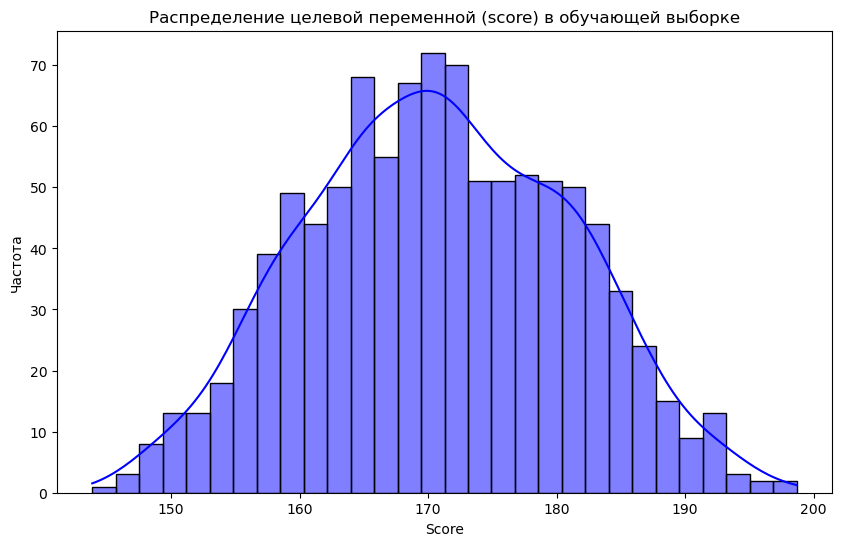

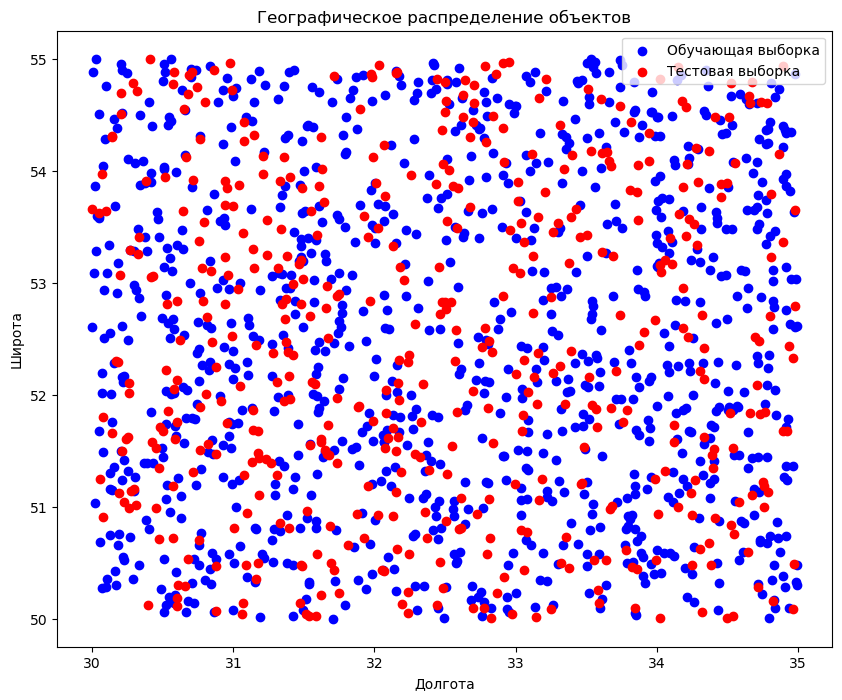

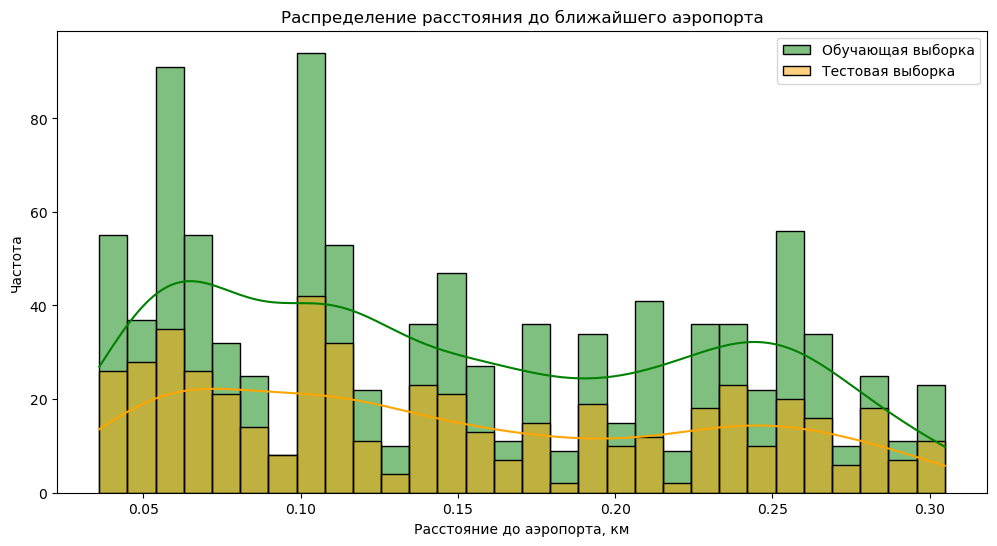

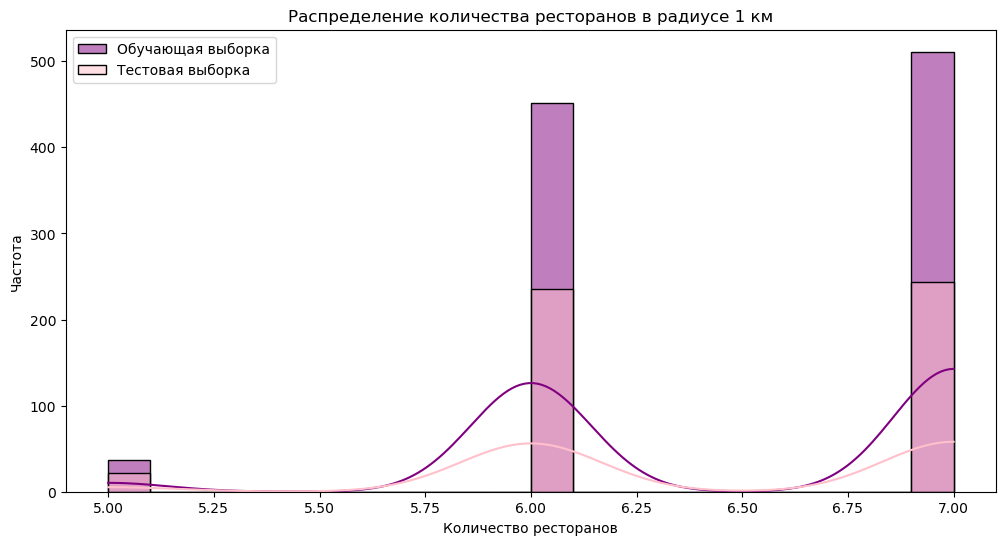

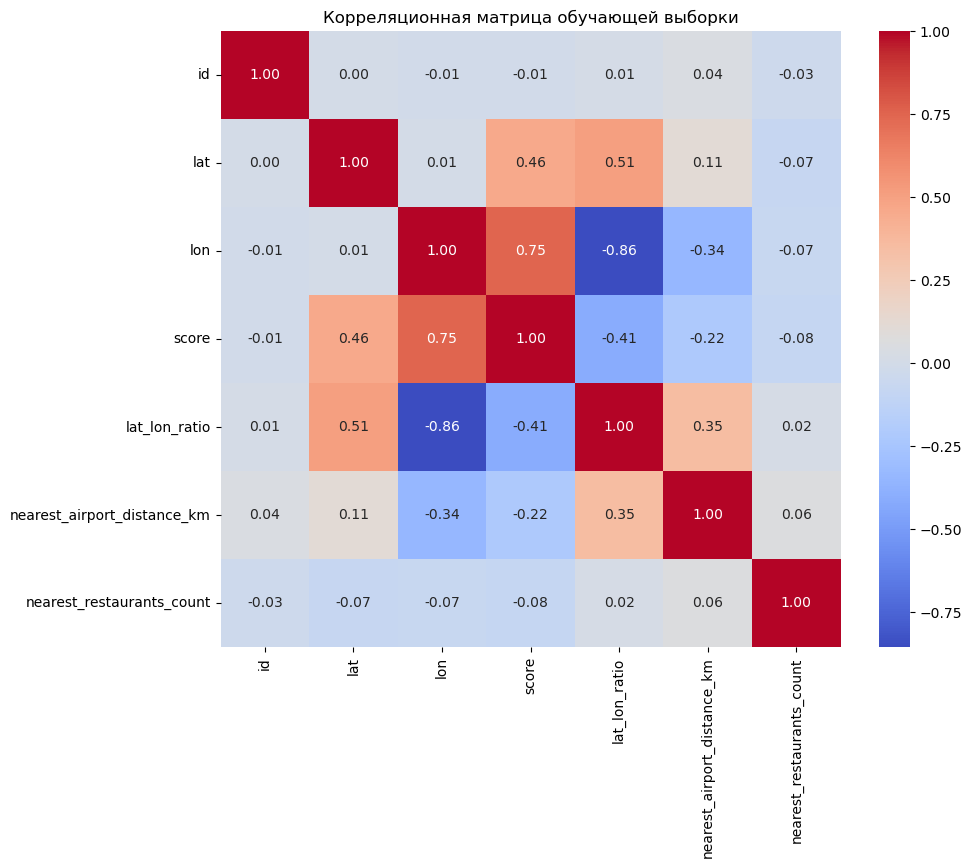

In [6]:
# 3. Анализ распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(train_data['score'], bins=30, kde=True, color='blue')
plt.title('Распределение целевой переменной (score) в обучающей выборке')
plt.xlabel('Score')
plt.ylabel('Частота')
plt.show()

# 4. Визуализация географического распределения объектов
plt.figure(figsize=(10, 8))
plt.scatter(train_data['lon'], train_data['lat'], color='blue', label='Обучающая выборка')
plt.scatter(test_data['lon'], test_data['lat'], color='red', label='Тестовая выборка')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Географическое распределение объектов')
plt.legend()
plt.show()

# 5. Анализ дополнительных признаков
plt.figure(figsize=(12, 6))
sns.histplot(train_data['nearest_airport_distance_km'], bins=30, kde=True, color='green', alpha=0.5, label='Обучающая выборка')
sns.histplot(test_data['nearest_airport_distance_km'], bins=30, kde=True, color='orange', alpha=0.5, label='Тестовая выборка')
plt.title('Распределение расстояния до ближайшего аэропорта')
plt.xlabel('Расстояние до аэропорта, км')
plt.ylabel('Частота')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train_data['nearest_restaurants_count'], bins=20, kde=True, color='purple', alpha=0.5, label='Обучающая выборка')
sns.histplot(test_data['nearest_restaurants_count'], bins=20, kde=True, color='pink', alpha=0.5, label='Тестовая выборка')
plt.title('Распределение количества ресторанов в радиусе 1 км')
plt.xlabel('Количество ресторанов')
plt.ylabel('Частота')
plt.legend()
plt.show()

# 6. Выявление корреляций между признаками и целевой переменной
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица обучающей выборки')
plt.show()

### Промежуточный вывод по проведенному исследовательскому анализу данных (EDA):



- Просмотр первых строк данных позволил нам ознакомиться с форматом данных и начать их анализ.
- Проверка типов данных и наличие пропущенных значений показала, что данные выглядят в целом чистыми, без пропусков, что облегчит дальнейший анализ.
- Анализ распределения целевой переменной (score) позволил увидеть, что она имеет относительно нормальное распределение.
- Визуализация географического распределения объектов показала, что объекты обучающей и тестовой выборок распределены похожим образом, что может быть полезной информацией для построения модели.
- Анализ дополнительных признаков (расстояние до ближайшего аэропорта и количество ресторанов в радиусе 1 км) позволил нам оценить их распределения и понять их потенциальное влияние на целевую переменную.
- Корреляционная матрица позволила выявить корреляции между признаками, что может быть полезным для дальнейшего отбора признаков перед построением модели.


Данные кажутся хорошо подготовленными для дальнейшего анализа и построения модели успешности объектов ритейла.

## Выбор моделей и их обучение

In [7]:
# Разделение данных на признаки и целевую переменную
X_train = train_data.drop(columns=['id', 'score'])
y_train = train_data['score']
X_test = test_data.drop(columns=['id', 'score'])
y_test = test_data['score']

Конечная цель  - подготовить модель машинного обучения для прогнозирования и использовать её для создания файла submission.csv с предсказанными оценками для тестовых данных.

- Подготовка гиперпараметров для моделей:

Создаются сетки гиперпараметров для моделей RandomForest и CatBoost. Гиперпараметры это настройки, которые не могут быть изучены моделью в процессе обучения, а должны быть заданы вручную.
Для RandomForest определены параметры n_estimators, max_depth, min_samples_split, min_samples_leaf.
Для CatBoost определены параметры iterations, depth, learning_rate.


- Обучение моделей с использованием кросс-валидации:

Используется метод кросс-валидации для оценки производительности моделей. Данные разбиваются на несколько подмножеств, на каждом из которых модель обучается и тестируется.
Для RandomForest применяется GridSearchCV, который ищет лучшие гиперпараметры перебирая все возможные комбинации из сетки параметров.
Для CatBoost применяется RandomizedSearchCV, который выбирает случайные комбинации гиперпараметров из сетки.


- Определение лучших моделей и их параметров:

Сравниваются средние абсолютные ошибки (MAE) для RandomForest и CatBoost.
Выбирается модель с наименьшей MAE.


- Обучение лучшей модели на всех обучающих данных:

Лучшая модель обучается на всех доступных обучающих данных.


- Предсказание оценок для тестовых данных и создание файла submission.csv:

Лучшая модель используется для предсказания оценок для тестовых данных.
Предсказанные оценки сохраняются в DataFrame с помощью pandas.
DataFrame записывается в файл submission.csv без индексов.


Кроме того, в коде осуществляется вывод информации о лучшей модели, её параметрах и средней абсолютной ошибке на кросс-валидации.

In [8]:
# Подготовка сетки гиперпараметров для RandomForest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Подготовка сетки гиперпараметров для CatBoost
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

# GridSearchCV для RandomForest
print("GridSearchCV для RandomForest...")
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=0)
rf_grid_search.fit(X_train, y_train)

# RandomizedSearchCV для CatBoost
print("RandomizedSearchCV для CatBoost...")
catboost_random_search = RandomizedSearchCV(CatBoostRegressor(random_state=42, verbose=0), param_distributions=catboost_param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', verbose=0)
catboost_random_search.fit(X_train, y_train)

# Определение лучшей модели и её параметров
best_rf_model = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_
best_rf_mae = -rf_grid_search.best_score_

best_catboost_model = catboost_random_search.best_estimator_
best_catboost_params = catboost_random_search.best_params_
best_catboost_mae = -catboost_random_search.best_score_

# Сравнение лучших MAE двух моделей
if best_rf_mae < best_catboost_mae:
    best_model = best_rf_model
    best_params = best_rf_params
    best_mae = best_rf_mae
    print("Лучшая модель: RandomForest")
else:
    best_model = best_catboost_model
    best_params = best_catboost_params
    best_mae = best_catboost_mae
    print("Лучшая модель: CatBoost")

# Вывод лучших параметров модели и её MAE
print("Лучшие параметры модели:", best_params)
print("MAE на кросс-валидации:", best_mae)

# Обучение лучшей модели на всех обучающих данных
print("Обучение лучшей модели на всех обучающих данных...")
best_model.fit(X_train, y_train)


GridSearchCV для RandomForest...
RandomizedSearchCV для CatBoost...
Лучшая модель: CatBoost
Лучшие параметры модели: {'learning_rate': 0.05, 'iterations': 100, 'depth': 4}
MAE на кросс-валидации: 4.0439541550582545
Обучение лучшей модели на всех обучающих данных...


In [9]:
# Подготовка предсказаний для submission.csv
print("Создание предсказаний...")
y_pred = best_model.predict(X_test)
submission_df = pd.DataFrame({'id': test_data['id'], 'score': y_pred})
submission_df.to_csv('submission.csv', index=False)

Создание предсказаний...


In [10]:
submission_df

,id,score
0,1001,164.595785
1,1002,167.260891
2,1003,188.086430
3,1004,165.593893
4,1005,184.076647
...,...,...
495,1496,164.544871
496,1497,164.190514
497,1498,176.906117
498,1499,173.636147


In [11]:
# Вычисляем среднюю абсолютную ошибку
mae = mean_absolute_error(y_test, y_pred)

print("MAE для тестовых данных:", mae)

MAE для тестовых данных: 4.046303761010145


## Вывод

После проведения поиска по сетке гиперпараметров с использованием GridSearchCV для модели RandomForest и RandomizedSearchCV для модели CatBoost, лучшей моделью оказалась CatBoost с параметрами learning_rate=0.05, iterations=100 и depth=4.

Среднее абсолютное отклонение (MAE) на кросс-валидации для лучшей модели CatBoost составило приблизительно 4.04.

MAE для тестовых данных: 4.05


Лучшая модель CatBoost была обучена на всех доступных обучающих данных.

После обучения лучшей модели были сгенерированы предсказания для тестовых данных и сохранены в файле 'submission.csv'.

На основании проведенного анализа и выбора модели, CatBoost с определенными гиперпараметрами оказался наилучшим выбором для данной задачи прогнозирования.